## Biophysical branching model

In this notebook, we leverage Jax in order to perform GPU accelerated simulation of branching model by simulating nutrient diffusion and density-dependent diffusion of cell dispersal.


In [39]:
%reset -f
# Import numerical jax dependencies
import jax
from jax import numpy as jnp
from jax import vmap

# For readability. 
from collections import namedtuple

# Import plotting dependencies
import matplotlib.pyplot as plt
from jax_tqdm import scan_tqdm
from IPython.display import clear_output
import time


In [40]:
# Define geometry of simulation in time and space. 
L = 120 # Length of side of domain. 
totalT = 20 # Simulation time length
dt = 0.005 # Integration time step
nt = int(totalT/dt) # Number of time steps

# Define the number of nodes of the simualtion. 
nx = 324 # Number of grid points
ny = nx # Number of grid points
dx = L / nx # Grid spacing
dy = dx # Grid spacing

# Create a FD grid
x = jnp.arange(-L/2, L/2,dx)
y = jnp.arange(-L/2, L/2,dy)
XX, YY = jnp.meshgrid(x, y)
RR = jnp.sqrt(XX**2 + YY**2)

# Create an analogous fourier transform of the grid for use in solving the diffusion PDE. 
kx = 2*jnp.pi*jnp.fft.fftfreq(x.shape[0], dx)
ky = 2*jnp.pi*jnp.fft.fftfreq(x.shape[0], dx)

KX, KY = jnp.meshgrid(kx, ky)
K = jnp.sqrt(KX**2 + KY**2)



In [41]:
@jax.jit
def dealias(u_hat):
    """
    Applies the 2/3 dealiasing rule to a 2D Fourier-transformed array.

    Parameters:
    - u_hat (jnp.ndarray): 2D Fourier-transformed array.

    Returns:
    - jnp.ndarray: Dealiased Fourier-transformed array.
    """
    nx, ny = u_hat.shape
    kx_cutoff = nx // 3
    ky_cutoff = ny // 3

    # Zero out high-frequency modes beyond the 2/3 cutoff in x-direction
    u_hat = u_hat.at[kx_cutoff:-kx_cutoff, :].set(0)

    # Zero out high-frequency modes beyond the 2/3 cutoff in y-direction
    u_hat = u_hat.at[:, ky_cutoff:-ky_cutoff].set(0)

    return u_hat


##### Computing the Wave Number Grid

Wave numbers are crucial for spectral differentiation. This function computes the squared wave number grid and the differential operators.

In [42]:
def compute_wave_numbers(nx, ny, Lx, Ly):
    """
    Computes the squared wave number grid and differentiation operators for spectral methods.

    Parameters:
    - nx (int): Number of grid points in the x-direction.
    - ny (int): Number of grid points in the y-direction.
    - Lx (float): Physical length of the domain in the x-direction.
    - Ly (float): Physical length of the domain in the y-direction.

    Returns:
    - K (jnp.ndarray): 2D array of squared wave numbers.
    - ikx (jnp.ndarray): 2D array of differentiation operators in x.
    - iky (jnp.ndarray): 2D array of differentiation operators in y.
    """
    kx = jnp.fft.fftfreq(nx, d=Lx / nx) * 2 * jnp.pi
    ky = jnp.fft.fftfreq(ny, d=Ly / ny) * 2 * jnp.pi
    Kx, Ky = jnp.meshgrid(kx, ky, indexing='ij')
    K = Kx**2 + Ky**2
    ikx = 1j * Kx
    iky = 1j * Ky
    return K, ikx, iky


##### PDE Update Function with Diffusion for Both 𝑁 and 𝐶

The core of the solver is the pde_update function, which updates the state of the PDE system using the Crank-Nicolson scheme for 𝑁 and a pseudo-spectral method for 𝐶 considering the nonlinear diffusion term: 𝐷eff = Dc * C

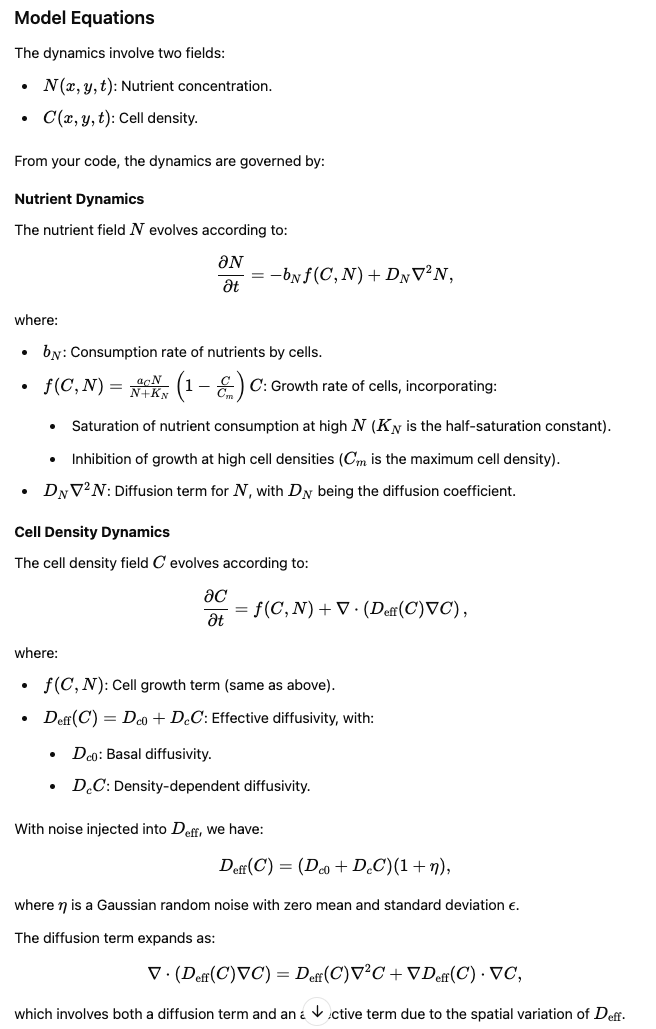

In [43]:
@jax.jit
def pde_update(pde_state, pde_params, K, ikx, iky, dt, noise):
    N, C = pde_state
    bN, KN, aC, DN, Cm, Dc0, Dc = pde_params

    # 1. Compute growth rate
    fC = aC * (N / (N + KN)) * (1 - C / Cm) * C
    # fC = aC * (1 - C / Cm) * C

    # 2. Update N consumption
    dN = -bN * fC

    # 3. Fourier transform N and apply dealiasing
#    N_hat = dealias(jnp.fft.fft2(N))
    N_hat = jnp.fft.fft2(N)
    dN_hat = dealias(jnp.fft.fft2(dN))

    # 4. Crank-Nicolson time-stepping for N
    pre_factor_N = 1.0 / (1.0 + 0.5 * DN * K * dt)
    post_factor_N = 1.0 - 0.5 * DN * K * dt
    N_new_hat = pre_factor_N * (post_factor_N * N_hat + dN_hat * dt)
    N_new = jnp.fft.ifft2(N_new_hat).real

    # 5. Compute gradients and Laplacian for C
#    C_hat = dealias(jnp.fft.fft2(C))
    C_hat = jnp.fft.fft2(C)
#    dCdx_hat = dealias(ikx * C_hat)
#    dCdy_hat = dealias(iky * C_hat)
    dCdx_hat = ikx * C_hat
    dCdy_hat = iky * C_hat
    dCdx = jnp.fft.ifft2(dCdx_hat).real
    dCdy = jnp.fft.ifft2(dCdy_hat).real
    gradC_squared = dCdx**2 + dCdy**2
    laplacian_C_hat = -K * C_hat


    laplacian_C = jnp.fft.ifft2(laplacian_C_hat).real
    
    # 6. Compute Deff with noise
    Deff = jnp.clip((Dc0 + Dc * C) * (1 + noise), 0, None)

    # 7. Compute diffusion term for C
    diffusion_term = Deff * laplacian_C + Dc * gradC_squared

    # 8. Update C
    C_new = C + (fC + diffusion_term) * dt

    # 9. Ensure non-negativity
    N_new = jnp.clip(N_new, 0, None)
    C_new = jnp.clip(C_new, 0, None)

    # 10. Enforce Dirichlet boundary conditions on C
    C_new = C_new.at[0, :].set(0).at[-1, :].set(0).at[:, 0].set(0).at[:, -1].set(0)

    return (N_new, C_new), None


In [44]:
import jax
import jax.numpy as jnp
from jax import jit
import matplotlib.pyplot as plt
import os
import numpy as np

@jit
def pde_update_fd(pde_state, pde_params, dx, dy, dt, noise):
    """
    Updates the PDE state using finite difference methods for N and C,
    incorporating additive noise into the effective diffusivity D_eff.

    Parameters:
    - pde_state (tuple): Current state of the PDE (N, C).
    - pde_params (tuple): Parameters (bN, KN, aC, DN, Cm, Dc0, Dc).
    - dx (float): Spatial step size in x-direction.
    - dy (float): Spatial step size in y-direction.
    - dt (float): Time step size.
    - noise (jnp.ndarray): 2D array of noise to inject into D_eff.
    - boundary (str): Type of boundary condition ('periodic', 'dirichlet', 'neumann').

    Returns:
    - tuple: Updated state (N_new, C_new), None
    """
    N, C = pde_state
    bN, KN, aC, DN, Cm, Dc0, Dc = pde_params

    # Define finite difference operators
    def laplacian(u):
        # Compute Laplacian using central differences
        lap = (
            (jnp.roll(u, 1, axis=0) - 2 * u + jnp.roll(u, -1, axis=0)) / dx**2 +
            (jnp.roll(u, 1, axis=1) - 2 * u + jnp.roll(u, -1, axis=1)) / dy**2
        )
        return lap


    # 1. Compute growth rate
    fC = aC * (N / (N + KN)) * (1 - C / Cm) * C

    # 2. Update N consumption
    dN = -bN * fC

    # 3. Update C via reaction
    dC = fC

    # 4. Compute Laplacians
    laplacian_N = laplacian(N)
    laplacian_C = laplacian(C)

    # 5. Compute Deff with additive noise
    Deff = (Dc0 + Dc * C) * (1 + noise)
    Deff = jnp.clip(Deff, 0, None)  # Ensure non-negative diffusivity

    # 6. Update equations using explicit Euler scheme
    N_new = N + dt * (DN * laplacian_N + dN)

    # Compute gradients for nonlinear term |∇C|^2
    dCdx = (jnp.roll(C, -1, axis=0) - jnp.roll(C, 1, axis=0)) / (2 * dx)
    dCdy = (jnp.roll(C, -1, axis=1) - jnp.roll(C, 1, axis=1)) / (2 * dy)
    gradC_squared = dCdx**2 + dCdy**2

    # 7. Update C
    C_new = C + dt * (dC + Deff * laplacian_C + Dc * gradC_squared)

    # 8. Ensure non-negativity
    N_new = jnp.clip(N_new, 0, None)
    C_new = jnp.clip(C_new, 0, None)

    return (N_new, C_new), None



In [45]:
def initialize_fields(nx, ny, Lx, Ly, N0, C0, R0):
    """
    Initializes the fields N and C with noise added to the center.

    Parameters:
    - nx (int): Number of grid points in the x-direction.
    - ny (int): Number of grid points in the y-direction.
    - Lx (float): Physical length of the domain in the x-direction.
    - Ly (float): Physical length of the domain in the y-direction.
    - N0 (float): Initial uniform concentration for N.
    - C0 (float): Initial concentration for C at the center.
    - R0 (float): Radius around the center with concentration C0.
    - noise_amplitude (float): Amplitude of the noise to be added to the center region.
    - seed (int): Random seed for reproducibility.

    Returns:
    - N_initial (jnp.ndarray): Initialized N field.
    - C_initial (jnp.ndarray): Initialized C field with noise in the center.
    """
    x = jnp.linspace(0, Lx, nx, endpoint=False)
    y = jnp.linspace(0, Ly, ny, endpoint=False)
    X, Y = jnp.meshgrid(x, y, indexing='ij')

    # Initialize N uniformly at N0
    N_initial = jnp.full((nx, ny), N0)

    # Initialize C at the center with concentration C0 within radius R0, 0 elsewhere
    center_x, center_y = Lx / 2, Ly / 2
    distance_squared = (X - center_x)**2 + (Y - center_y)**2

    # Generate noise only within the radius R0
    key = jax.random.PRNGKey(42)
    noise = jax.random.normal(key, shape=(nx, ny)) * 0.1
    noise_mask = jnp.where(distance_squared <= R0**2, 1.0, 0.0)  # Noise only in the center region

    # Add noise to the center region
    C_initial = jnp.where(distance_squared <= R0**2, 0.5 * C0, 0.0) + noise * noise_mask

    # Ensure non-negative concentrations
    C_initial = jnp.clip(C_initial, 0.0, None)

    return N_initial, C_initial


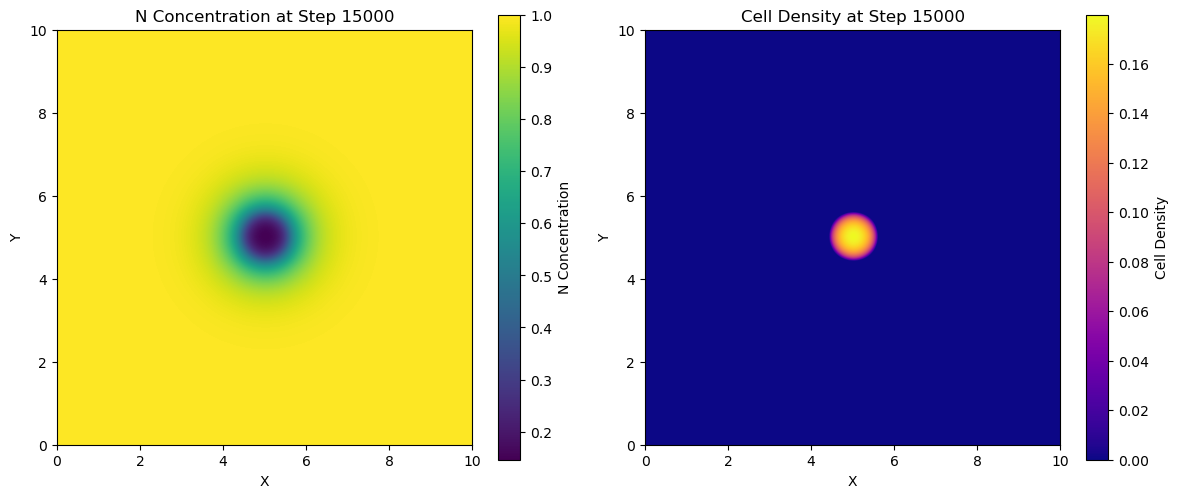

Step 15000: Simulation progress 10.00%, Total N = 97.6627, Total C = 0.1239, Colony Radius = 0.5932


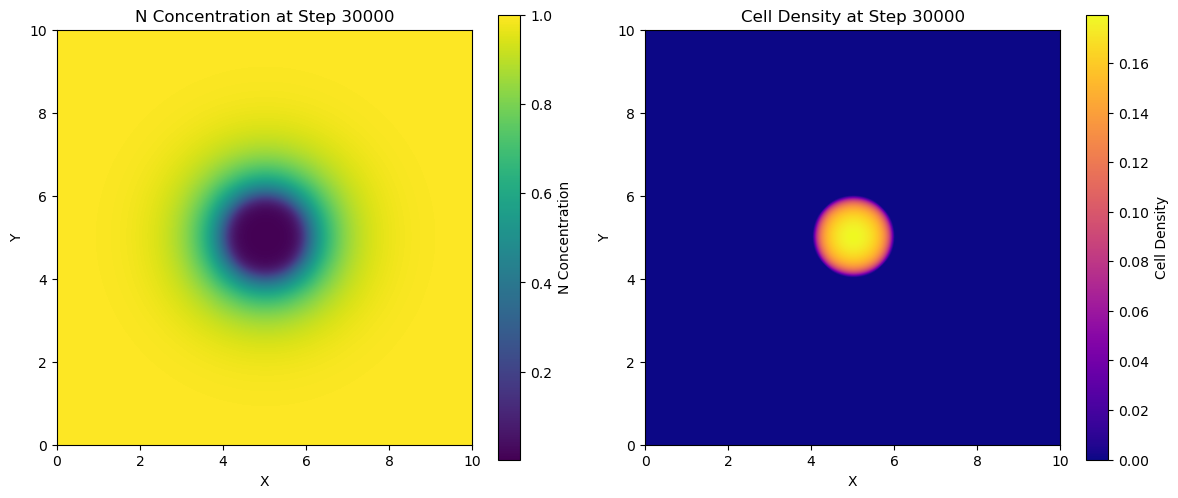

Step 30000: Simulation progress 20.00%, Total N = 92.4125, Total C = 0.3784, Colony Radius = 0.9845


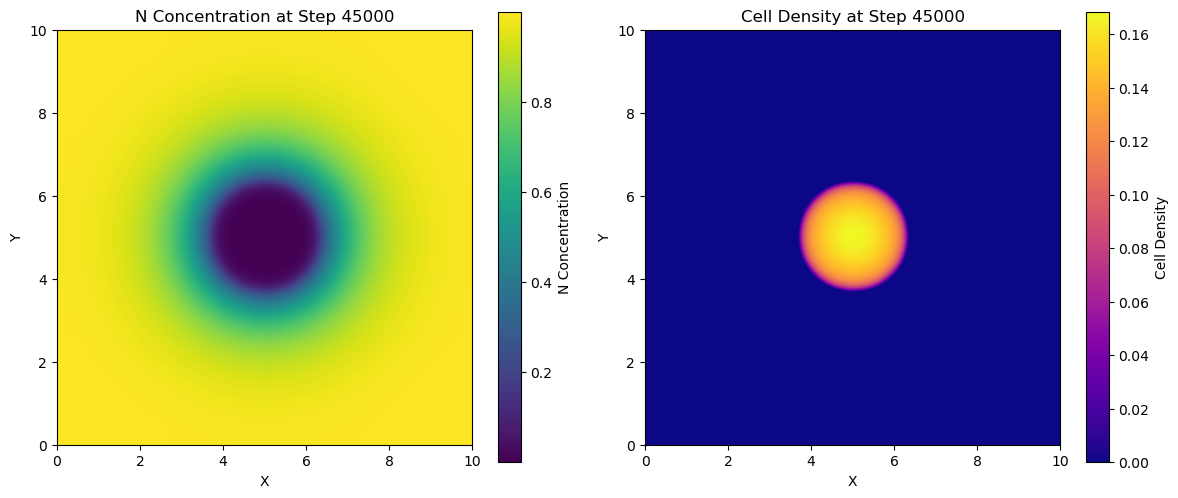

Step 45000: Simulation progress 30.00%, Total N = 86.1188, Total C = 0.6833, Colony Radius = 1.3383


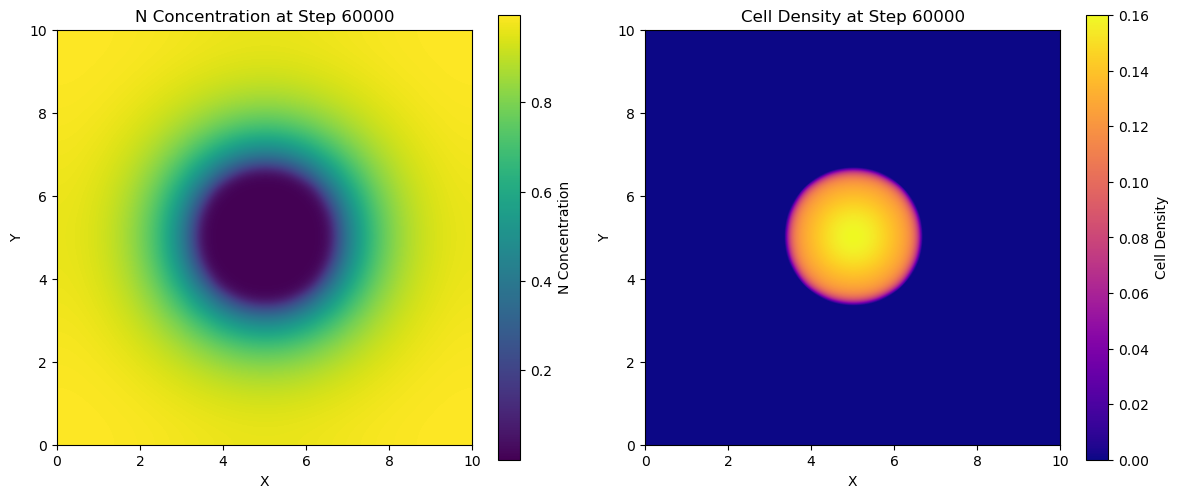

Step 60000: Simulation progress 40.00%, Total N = 79.1159, Total C = 1.0226, Colony Radius = 1.6670


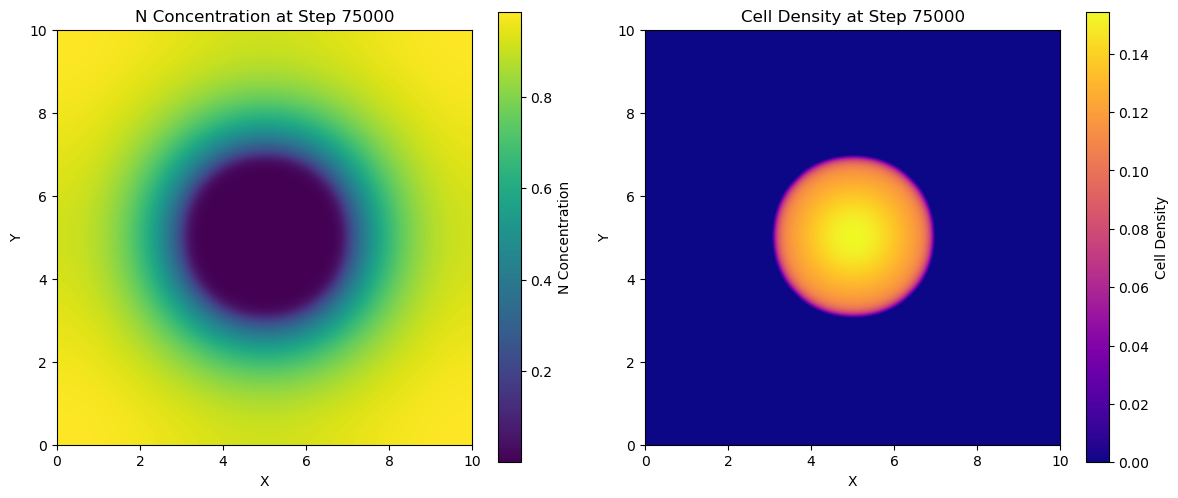

Step 75000: Simulation progress 50.00%, Total N = 71.5337, Total C = 1.3900, Colony Radius = 1.9756


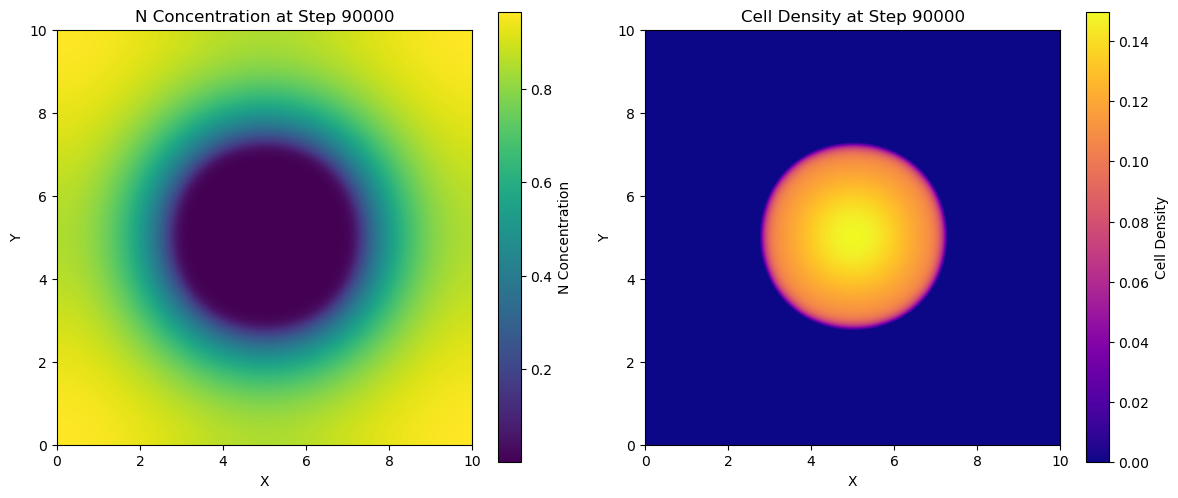

Step 90000: Simulation progress 60.00%, Total N = 63.4794, Total C = 1.7804, Colony Radius = 2.2703


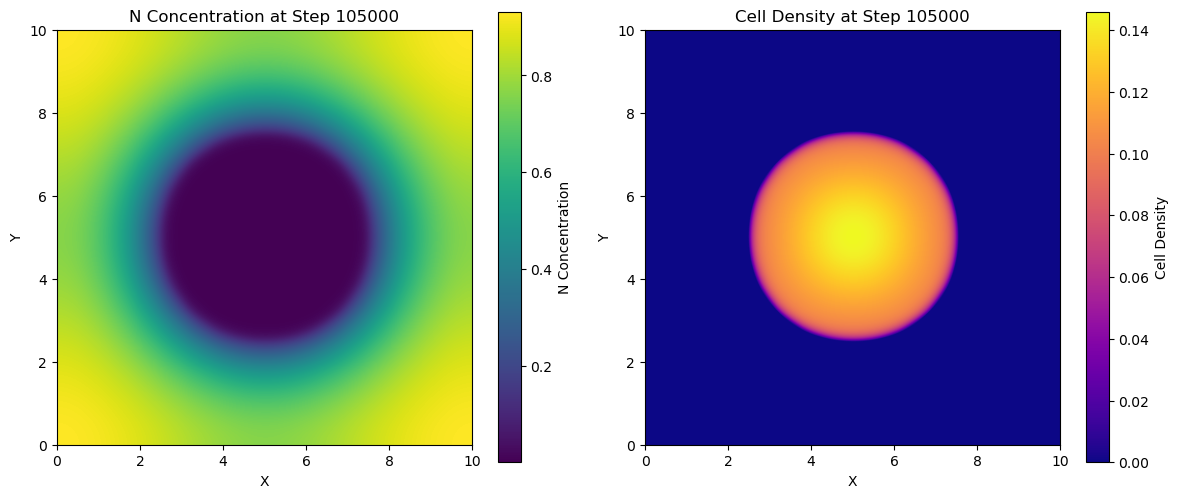

Step 105000: Simulation progress 70.00%, Total N = 55.0853, Total C = 2.1873, Colony Radius = 2.5522


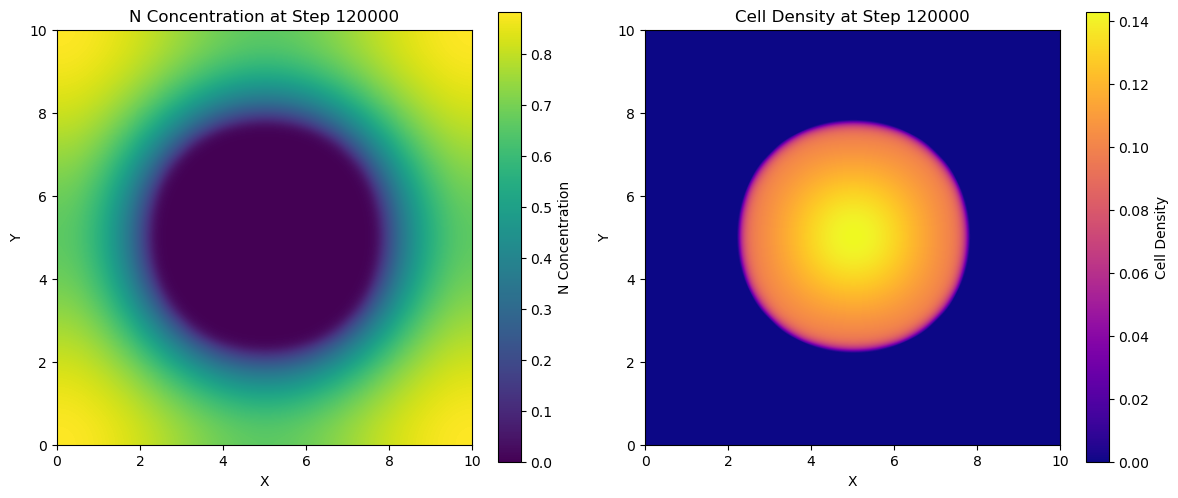

Step 120000: Simulation progress 80.00%, Total N = 46.5365, Total C = 2.6016, Colony Radius = 2.8216


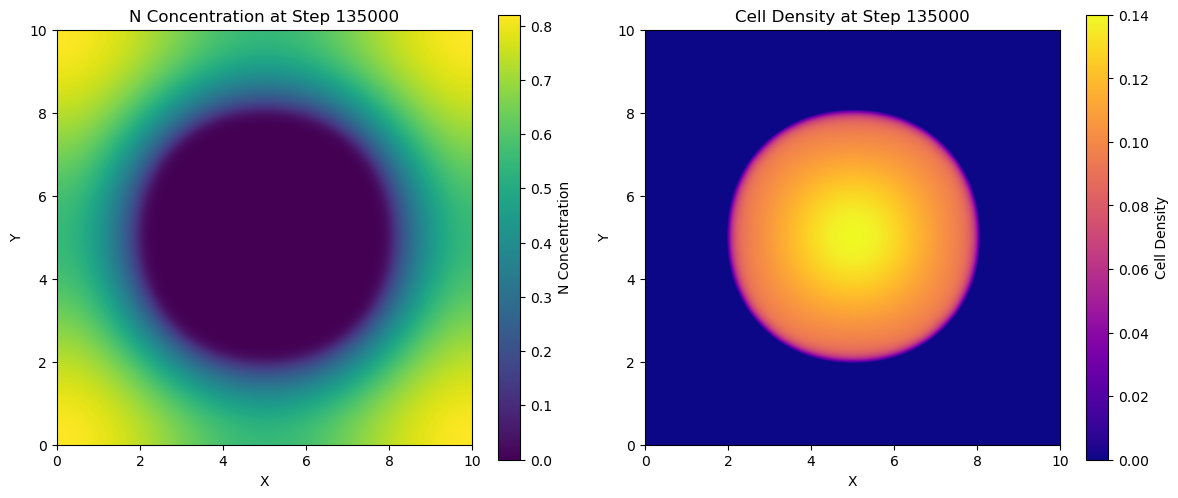

Step 135000: Simulation progress 90.00%, Total N = 38.0826, Total C = 3.0113, Colony Radius = 3.0788


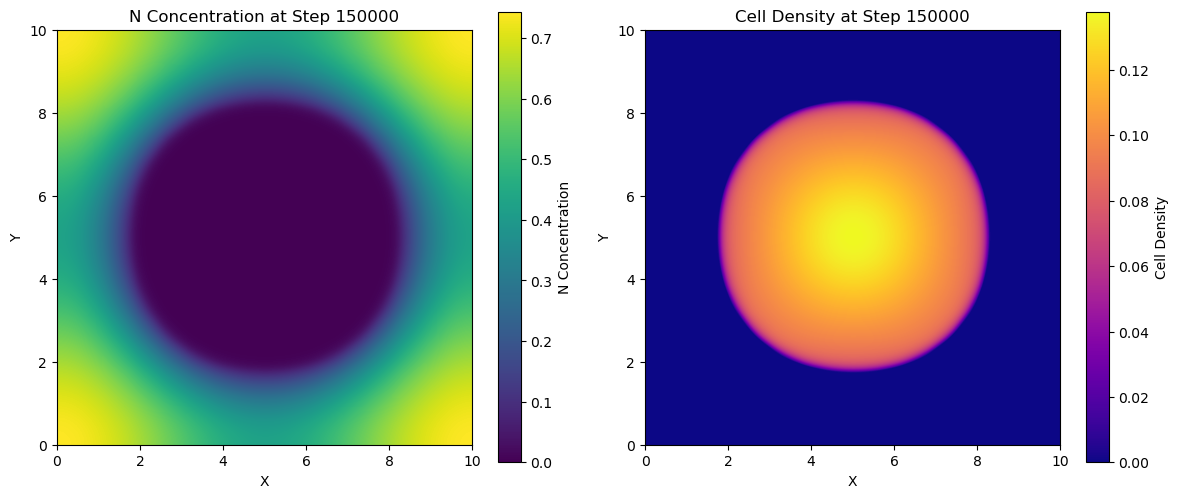

Step 150000: Simulation progress 100.00%, Total N = 30.0310, Total C = 3.4014, Colony Radius = 3.3210
Simulation completed.


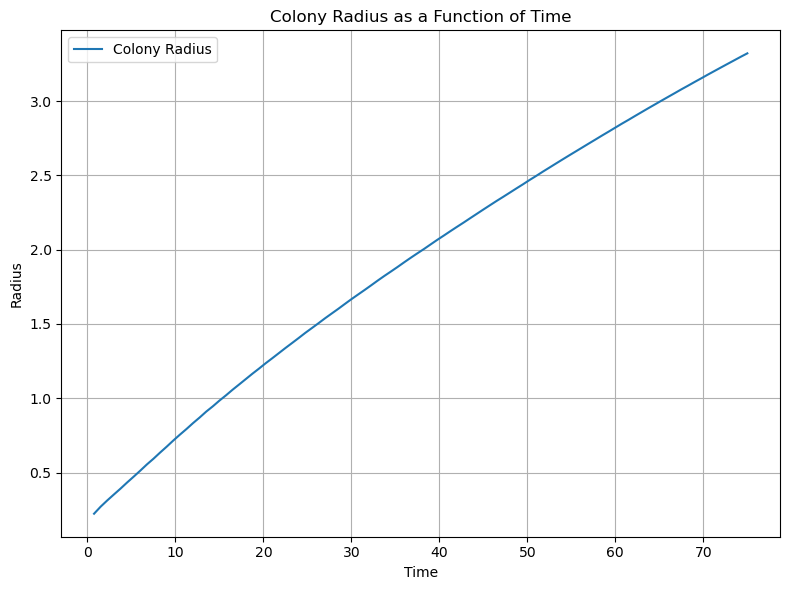

Simulation took 93.33 seconds


In [53]:
import time

def run_simulation():
    """
    Runs the PDE simulation for nutrient concentration (N) and cell density (C),
    injecting noise into the effective diffusivity D_eff. Computes colony area by
    thresholding C > 0.01 and plots colony radius as a function of time.
    """
    # Define grid parameters
    nx, ny = 400, 400  # Number of grid points
    Lx, Ly = 10.0, 10.0  # Physical domain size

    # Compute wave number grid and differentiation operators
#    K, ikx, iky = compute_wave_numbers(nx, ny, Lx, Ly)
    # K, ikx, iky = compute_wave_numbers_upscaled(nx, ny, Lx, Ly, 2)

    # Define initial conditions
    N0 = 1.0    # Uniform initial concentration for N
    C0 = 1.0    # Initial concentration for C at the center
    R0 = 0.1    # Radius for initial C concentration

    N_initial, C_initial = initialize_fields(nx, ny, Lx, Ly, N0, C0, R0)
    pde_state = (N_initial, C_initial)

    # Define PDE parameters
    bN = 20.0     # Reaction rate for N
    KN = 0.1    # Half-saturation constant for N
    aC = 1.0     # Reaction rate for C
    DN = 0.1    # Diffusion coefficient for N
    Cm = 0.2    # Constant for C
    Dc0 = 1e-8    # Basal diffusivity for C
    Dc = 0.05   # Density-dependent diffusivity coefficient for C

    pde_params = (bN, KN, aC, DN, Cm, Dc0, Dc)

    # Define time step and number of steps
    dt = 0.0005
    num_steps = 150000
    num_frames = 10
    num_samples = 100

    # Define noise parameters
    epsilon = 0.2  # Noise amplitude; adjust as needed

    # Initialize PRNG key
    seed = 42  # Arbitrary seed for reproducibility
    key = jax.random.PRNGKey(seed)

    # Initialize lists to store total concentrations and colony radius
    total_N_list = []
    total_C_list = []
    colony_radius_list = []
    time_list = []

    # Define threshold for colony
    C_threshold = 0.001

    # Compute cell area
    dx = Lx / nx
    dy = Ly / ny
    cell_area = dx * dy

    # Simulation loop
    for step in range(1, num_steps + 1):
        # Generate a new random key for this step
        key, subkey = jax.random.split(key)

        # Generate noise: Gaussian noise with mean 0 and standard deviation epsilon
        noise = epsilon * jax.random.normal(subkey, shape=(nx, ny))

        # Update PDE state with noise injected into D_eff
        #pde_state, _ = pde_update(
        #    pde_state,
        #    pde_params,
        #    K,
        #    ikx,
        #    iky,
        #    dt,
        #    noise
        #)

        # Update PDE state with noise injected into D_eff
        pde_state, _ = pde_update_fd(
            pde_state,
            pde_params,
            dx,
            dy,
            dt,
            noise
        )

        # Extract updated N and C
        N, C = pde_state

        if step % (num_steps//num_samples) == 0:
            # Compute total concentrations
            total_N = jnp.sum(N) * cell_area
            total_C = jnp.sum(C) * cell_area
            total_N_list.append(total_N)
            total_C_list.append(total_C)

            # Compute colony area by thresholding C > C_threshold
            colony_mask = C > C_threshold
            colony_area = jnp.sum(colony_mask) * cell_area

            # Compute colony radius assuming circular colony
            colony_radius = jnp.sqrt(colony_area / jnp.pi)
            colony_radius_list.append(colony_radius)
            time_list.append(step * dt)

        # Optional: Visualization and data saving every 500 steps
        if step %  (num_steps//num_frames)== 0:
            plt.figure(figsize=(12, 5))

            # Plot N
            plt.subplot(1, 2, 1)
            plt.imshow(N, extent=(0, Lx, 0, Ly), origin='lower', cmap='viridis')
            plt.colorbar(label='N Concentration')
            plt.title(f'N Concentration at Step {step}')
            plt.xlabel('X')
            plt.ylabel('Y')

            # Plot C
            plt.subplot(1, 2, 2)
            plt.imshow(C, extent=(0, Lx, 0, Ly), origin='lower', cmap='plasma')
            plt.colorbar(label='Cell Density')
            plt.title(f'Cell Density at Step {step}')
            plt.xlabel('X')
            plt.ylabel('Y')

            plt.tight_layout()
            plt.show()
            # plt.close()

            # Print progress, total concentrations, and colony radius
            print(f"Step {step}: Simulation progress {step/num_steps*100:.2f}%, "
                  f"Total N = {total_N:.4f}, Total C = {total_C:.4f}, "
                  f"Colony Radius = {colony_radius:.4f}")

    print("Simulation completed.")

    # Convert lists to NumPy arrays for plotting
    colony_radius_array = jnp.array(colony_radius_list)
    time_array = jnp.array(time_list)

    # Plot Colony Radius vs Time
    plt.figure(figsize=(8, 6))
    plt.plot(time_array, colony_radius_array, label='Colony Radius')
    plt.xlabel('Time')
    plt.ylabel('Radius')
    plt.title('Colony Radius as a Function of Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

start = time.time()
run_simulation()
end = time.time()
print(f"Simulation took {end - start:.2f} seconds")
